In [1]:
import ROOT as r
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import pickle

from sklearn.model_selection import train_test_split

Welcome to JupyROOT 6.18/04


## Intro

The purpose of this notebook is to train and test a machine learning algorithm to determine the number of pulses in an island. It should be able to look at an island and tells us with x% confidence that it is a single, double, triple, or quadruple pile up event

This notebook just takes a look at a bunch of algorithms to see how fast they run, how accurate they are on very basic training data

## Load in the data

In [2]:
directory = './template_data/set_3/'

with open(directory + 'x.data', 'rb') as xFile:
    biggestX = pickle.load(xFile)
    bigX = []
    for x in biggestX:
        bigX.append(x[1])
    xFile.close()
    
with open(directory + 'y.data', 'rb') as yFile:
    bigY = pickle.load(yFile)
    yFile.close()

In [3]:
x_train, x_test, y_train, y_test = train_test_split(bigX, bigY, test_size=0.2)

In order to test accuracy for a given number of pulses, split the test data by pulse number

In [4]:
test_data = pd.DataFrame({'x_test': x_test, 'y_test': y_test})
split_test_data = {}
for index in range(0, 5):
    split_test_data[index] = (test_data[test_data['y_test'] == index])

In [7]:
results_table = pd.read_csv(directory + 'results.csv')
results_table = pd.DataFrame({'nPulses': ['0', '1', '2', '3', '4']})
results_table.to_csv(directory + 'results.csv')

## ML Time

I only kind of know what I am doing, so let's just use every model from https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png and see what happens

### Nearest Neighbors

In [6]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train, y_train)

KNeighborsClassifier()

In [7]:
from sklearn.metrics import accuracy_score
nnScore = accuracy_score(y_test, neigh.predict(x_test))
print(nnScore)

0.7295635218239088


Ok cool beans, but what if as example the ~27% it misses are because 25% are quadruples and are hard, and it is getting everything else right? Probably not, but still we should check. Split the test set into n=0, 1, 2, 3, 4 and get accuracy scores for each to see what things look like

In [10]:
nums = []
nnSplitScores = []
for nPulses, thing in split_test_data.items():
    nums.append(nPulses)
    nnSplitScores.append(accuracy_score(list(thing['y_test']), neigh.predict(list(thing['x_test']))))

results_table = pd.read_csv(directory + 'results.csv')
results_table['NN'] = nnSplitScores
results_table.to_csv(directory + 'results.csv')

Text(0.5, 1.0, 'Nearest Neighbors')

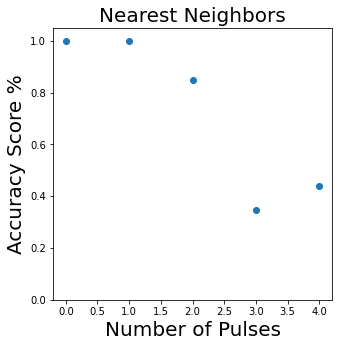

In [11]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)

ax.plot(nums, nnSplitScores, linestyle='None', marker='o')

ax.set_ylabel('Accuracy Score %', fontsize=20)
ax.set_xlabel('Number of Pulses', fontsize=20)
ax.set_ylim(0, 1.05)
ax.set_title("Nearest Neighbors", fontsize=20)

### SVC

This took a *long* time to run, as did linear svc. Worse predictions than nearest neighbor too, so probably not what we want

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [55]:
from sklearn.metrics import accuracy_score
svcScore = accuracy_score(y_test, clf.predict(x_test))
print(svcScore)

0.743662816859157


Text(0.5, 1.0, 'Support Vector Classification')

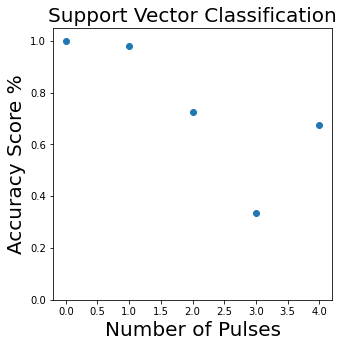

In [13]:
nums = []
svcSplitScores = []
for nPulses, thing in split_test_data.items():
    nums.append(nPulses)
    svcSplitScores.append(accuracy_score(list(thing['y_test']), clf.predict(list(thing['x_test']))))
    
results_table = pd.read_csv(directory + 'results.csv')
results_table['SVC'] = svcSplitScores
results_table.to_csv(directory + 'results.csv')
    
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)

ax.plot(nums, svcSplitScores, linestyle='None', marker='o')

ax.set_ylabel('Accuracy Score %', fontsize=20)
ax.set_xlabel('Number of Pulses', fontsize=20)
ax.set_ylim(0, 1.05)
ax.set_title("Support Vector Classification", fontsize=20)

### Linear SVC

by default, max_iter=1000 and we failed to converge.
still fails at 10000, so maybe don't use this one

In [14]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

linclf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, max_iter=100))
linclf.fit(x_train, y_train)

#from sklearn.metrics import accuracy_score
#linsvcScore = accuracy_score(y_test, linclf.predict(x_test))
#print(linsvcScore)

/home/lars/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(max_iter=100, random_state=0, tol=1e-05))])

Text(0.5, 1.0, 'Linear Support Vector Classification')

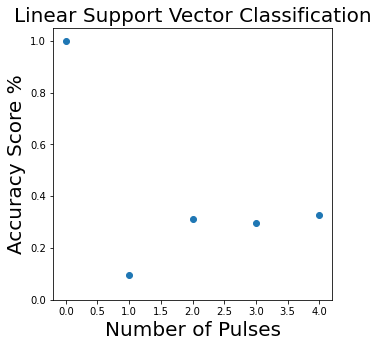

In [15]:
nums = []
linsvcSplitScores = []
for nPulses, thing in split_test_data.items():
    nums.append(nPulses)
    linsvcSplitScores.append(accuracy_score(list(thing['y_test']), linclf.predict(list(thing['x_test']))))

results_table = pd.read_csv(directory + 'results.csv')
results_table['LSVC'] = linsvcSplitScores
results_table.to_csv(directory + 'results.csv')
    
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)

ax.plot(nums, linsvcSplitScores, linestyle='None', marker='o')

ax.set_ylabel('Accuracy Score %', fontsize=20)
ax.set_xlabel('Number of Pulses', fontsize=20)
ax.set_ylim(0, 1.05)
ax.set_title("Linear Support Vector Classification", fontsize=20)

### Gaussian Process Classifier

This one is crazy memory intensive. Using the full 80,000 train data memory usage went to 25gb from this alone. Understandable tbh but maybe dial it back usually

Dial it back a lot. 1,000 train points works pretty fast and is what was used here

In [5]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(x_train[0:(len(x_train)//80)], y_train[0:(len(y_train)//80)])
gpc.score(x_train[0:(len(x_train)//80)], y_train[0:(len(y_train)//80)])

#from sklearn.metrics import accuracy_score
#gpcScore = accuracy_score(y_test, gpc.predict(x_test))
#print(gpcScore)

0.82

Text(0.5, 1.0, 'Gaussian Process Classifier')

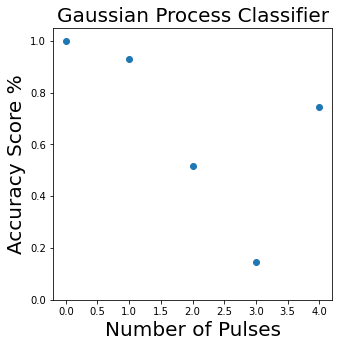

In [8]:
from sklearn.metrics import accuracy_score
nums = []
gpcSplitScores = []
for nPulses, thing in split_test_data.items():
    nums.append(nPulses)
    gpcSplitScores.append(accuracy_score(list(thing['y_test'][:1000]), gpc.predict(list(thing['x_test'][:1000]))))

results_table = pd.read_csv(directory + 'results.csv')
results_table['GPC'] = gpcSplitScores
results_table.to_csv(directory + 'results.csv')
    
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)

ax.plot(nums, gpcSplitScores, linestyle='None', marker='o')

ax.set_ylabel('Accuracy Score %', fontsize=20)
ax.set_xlabel('Number of Pulses', fontsize=20)
ax.set_ylim(0, 1.05)
ax.set_title("Gaussian Process Classifier", fontsize=20)

### Decision Tree Classifier

this one went very quickly

In [8]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

#from sklearn.metrics import accuracy_score
#dtcScore = accuracy_score(y_test, model.predict(x_test))
#print(dtcScore)

DecisionTreeClassifier()

Text(0.5, 1.0, 'Decision Tree Classifier')

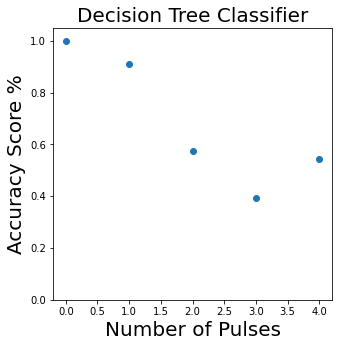

In [9]:
from sklearn.metrics import accuracy_score
nums = []
dctSplitScores = []
for nPulses, thing in split_test_data.items():
    nums.append(nPulses)
    dctSplitScores.append(accuracy_score(list(thing['y_test']), model.predict(list(thing['x_test']))))

results_table = pd.read_csv(directory + 'results.csv')
results_table['DCT'] = dctSplitScores
results_table.to_csv(directory + 'results.csv')
    
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)

ax.plot(nums, dctSplitScores, linestyle='None', marker='o')

ax.set_ylabel('Accuracy Score %', fontsize=20)
ax.set_xlabel('Number of Pulses', fontsize=20)
ax.set_ylim(0, 1.05)
ax.set_title("Decision Tree Classifier", fontsize=20)

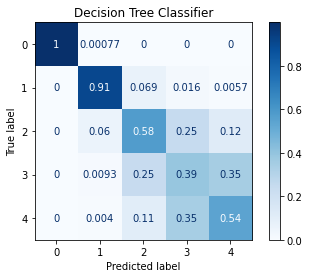

[[9.99233716e-01 7.66283525e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 9.09113361e-01 6.93998518e-02 1.58063719e-02
  5.68041492e-03]
 [0.00000000e+00 5.96307385e-02 5.76596806e-01 2.46257485e-01
  1.17514970e-01]
 [0.00000000e+00 9.32744232e-03 2.45213549e-01 3.94207167e-01
  3.51251841e-01]
 [0.00000000e+00 4.04551201e-03 1.06700379e-01 3.45132743e-01
  5.44121365e-01]]


In [28]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
matrix = plot_confusion_matrix(model, x_test,
                               y_test, cmap=plt.cm.Blues,
                              normalize='true')

plt.title('Decision Tree Classifier')
plt.show(matrix)
plt.show()

matrix2 = confusion_matrix(y_true=y_test, y_pred=model.predict(x_test[:20001]), normalize='true')
#confusionDf = pd.DataFrame(columns = ['0', '1', '2', '3', '4'])

print(matrix2)

confusionDf = pd.DataFrame(data=matrix2, index=['0', '1', '2', '3', '4'], columns=['0', '1', '2', '3', '4'])



### Random Forest Classifier

this one also went very quickly

In [11]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

#from sklearn.metrics import accuracy_score
#dtcScore = accuracy_score(y_test, model.predict(x_test))
#print(dtcScore)

RandomForestClassifier()

Text(0.5, 1.0, 'Random Forest Classifier')

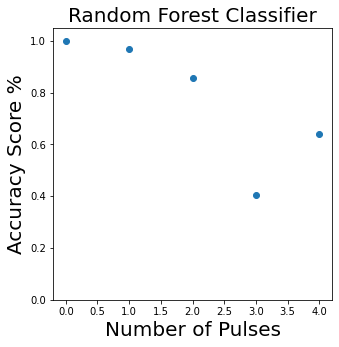

In [13]:
nums = []
rfcSplitScores = []
for nPulses, thing in split_test_data.items():
    nums.append(nPulses)
    rfcSplitScores.append(accuracy_score(list(thing['y_test']), rfc.predict(list(thing['x_test']))))

results_table = pd.read_csv(directory + 'results.csv')
results_table['RFC'] = rfcSplitScores
results_table.to_csv(directory + 'results.csv')
    
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)

ax.plot(nums, rfcSplitScores, linestyle='None', marker='o')

ax.set_ylabel('Accuracy Score %', fontsize=20)
ax.set_xlabel('Number of Pulses', fontsize=20)
ax.set_ylim(0, 1.05)
ax.set_title("Random Forest Classifier", fontsize=20)

### MLP Classifier

didn't converge with default 200 iterations, and took around 10 minutes

In [14]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(x_train, y_train)

/home/lars/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier()

Text(0.5, 1.0, 'Multi-Layer Perceptron Classifier')

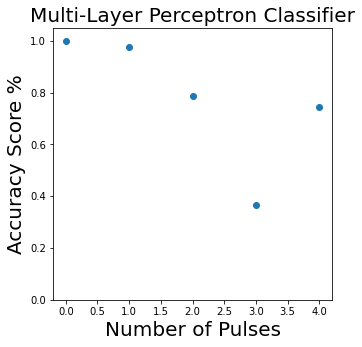

In [15]:
nums = []
mlpSplitScores = []
for nPulses, thing in split_test_data.items():
    nums.append(nPulses)
    mlpSplitScores.append(accuracy_score(list(thing['y_test']), mlp.predict(list(thing['x_test']))))

results_table = pd.read_csv(directory + 'results.csv')
results_table['MLP'] = mlpSplitScores
results_table.to_csv(directory + 'results.csv')
    
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)

ax.plot(nums, mlpSplitScores, linestyle='None', marker='o')

ax.set_ylabel('Accuracy Score %', fontsize=20)
ax.set_xlabel('Number of Pulses', fontsize=20)
ax.set_ylim(0, 1.05)
ax.set_title("Multi-Layer Perceptron Classifier", fontsize=20)

### Ada Boost Classifier

In [16]:
from sklearn.ensemble import AdaBoostClassifier

adacl = AdaBoostClassifier()
adacl.fit(x_train, y_train)

AdaBoostClassifier()

Text(0.5, 1.0, 'AdaBoost Classifier')

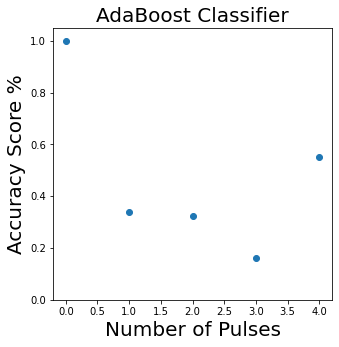

In [17]:
nums = []
adaclSplitScores = []
for nPulses, thing in split_test_data.items():
    nums.append(nPulses)
    adaclSplitScores.append(accuracy_score(list(thing['y_test']), adacl.predict(list(thing['x_test']))))

results_table = pd.read_csv(directory + 'results.csv')
results_table['ADA'] = adaclSplitScores
results_table.to_csv(directory + 'results.csv')
    
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)

ax.plot(nums, adaclSplitScores, linestyle='None', marker='o')

ax.set_ylabel('Accuracy Score %', fontsize=20)
ax.set_xlabel('Number of Pulses', fontsize=20)
ax.set_ylim(0, 1.05)
ax.set_title("AdaBoost Classifier", fontsize=20)

### Gaussian NB

alarmingly fast

In [18]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB()

Text(0.5, 1.0, 'Gaussian Naive Bayes Classifier')

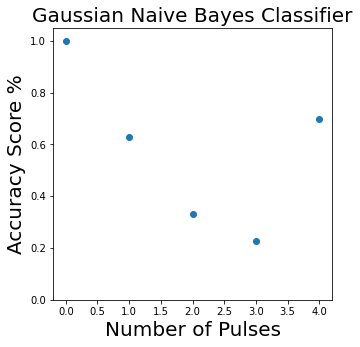

In [19]:
nums = []
gnbSplitScores = []
for nPulses, thing in split_test_data.items():
    nums.append(nPulses)
    gnbSplitScores.append(accuracy_score(list(thing['y_test']), gnb.predict(list(thing['x_test']))))

results_table = pd.read_csv(directory + 'results.csv')
results_table['GNB'] = gnbSplitScores
results_table.to_csv(directory + 'results.csv')
    
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)

ax.plot(nums, gnbSplitScores, linestyle='None', marker='o')

ax.set_ylabel('Accuracy Score %', fontsize=20)
ax.set_xlabel('Number of Pulses', fontsize=20)
ax.set_ylim(0, 1.05)
ax.set_title("Gaussian Naive Bayes Classifier", fontsize=20)

## Put it all together for an overview

In [5]:
data = pd.DataFrame(columns=['nPulses','NN','SVC','LSVC','GPC','DCT','RFC','MLP','ADA','GNB'])
data.loc[0] = [0,1,1,1,1,1,1,1,1,1]
data.loc[1] = [1,0.999265426,0.982370225,0.094025465,0.931,0.953268705,0.969922943,0.977380065,0.340044743,0.628138205]
data.loc[2] = [2,0.847398556,0.727408514,0.31292009,0.518,0.693284493,0.855189255,0.786813187,0.322344322,0.32967033]
data.loc[3] = [3,0.348672566,0.335018963,0.298103666,0.147,0.449429658,0.405830165,0.367553866,0.162737643,0.226869455]
data.loc[4] = [4,0.438592049,0.677133452,0.327424664,0.743,0.580035291,0.642046887,0.746659945,0.549785732,0.700277288]


data.to_csv(directory + 'results.csv')

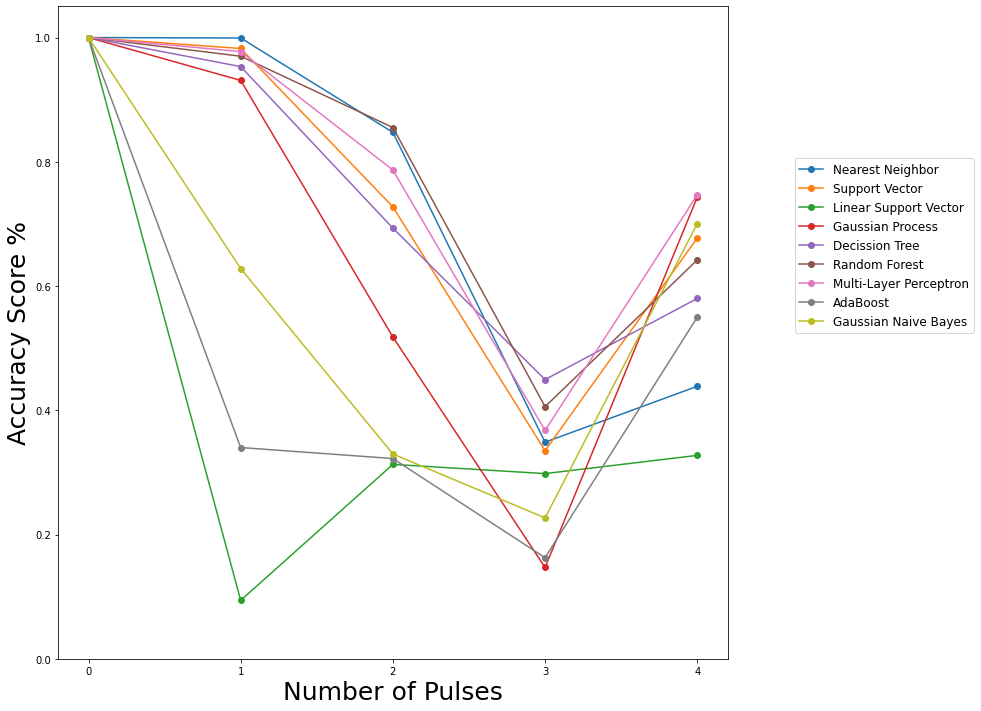

In [6]:
fig, ax = plt.subplots(1,1);
fig.set_size_inches(12,12);

#data = pd.read_csv(directory + 'results.csv')




labels = {
    'NN': 'Nearest Neighbor',
    'SVC': 'Support Vector',
    'LSVC': 'Linear Support Vector',
    'GPC': 'Gaussian Process',
    'DCT': 'Decission Tree',
    'RFC': 'Random Forest',
    'MLP': 'Multi-Layer Perceptron',
    'ADA': 'AdaBoost',
    'GNB': 'Gaussian Naive Bayes'
}

for s, l in labels.items():
    ax.plot(data['nPulses'], data[s], marker='o', label=l);

ax.set_ylabel('Accuracy Score %', fontsize=25);
ax.set_xlabel('Number of Pulses', fontsize=25);
plt.xticks([0, 1, 2, 3, 4])
ax.set_ylim(0, 1.05);
ax.legend(loc=(1.1, 0.5), fontsize='large');